In [6]:
#добавляем импорты
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.pipeline import make_pipeline
from tqdm.auto import tqdm
import warnings

In [7]:
#Загружаем данные
df = pd.read_csv('cleaned_comments.csv', delimiter='\t', header=0)

#Удалякм колонки Unnamed
df.drop(columns=[col for col in df.columns if col.startswith('Unnamed')], inplace=True)

#Создание нового столбца для комментариев
df['comment'] = ''

# Перебор всех строк для перемещения комментариев
for idx, row in df.iterrows():
    #Поиск первого непустого строкового значения в строке
    comment = next((v for v in row if isinstance(v, str) and v.strip()), '')
    
    #Запись комментария в новый столбец
    df.at[idx, 'comment'] = comment
    
    #Обнуление исходных столбцов и установка флагов
    for col in df.columns[:-1]:  #Все столбцы кроме нового 'comment'
        df.at[idx, col] = 1 if str(row[col]).strip() == comment.strip() else 0

#Сохранение результата
df.to_csv('processed_comments.csv', index=False)

╒════════════════════════════════╕
│ Обнаруженные столбцы в файле:  │
╘════════════════════════════════╛
['Вопрос решен', 'Вопрос не решен ', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'comment'] 



Прогресс обработки: 100%|██████████| 1735/1735 [00:00<00:00, 1881.63it/s]
C:\Users\Евгения\AppData\Local\Temp\ipykernel_9980\3818197587.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


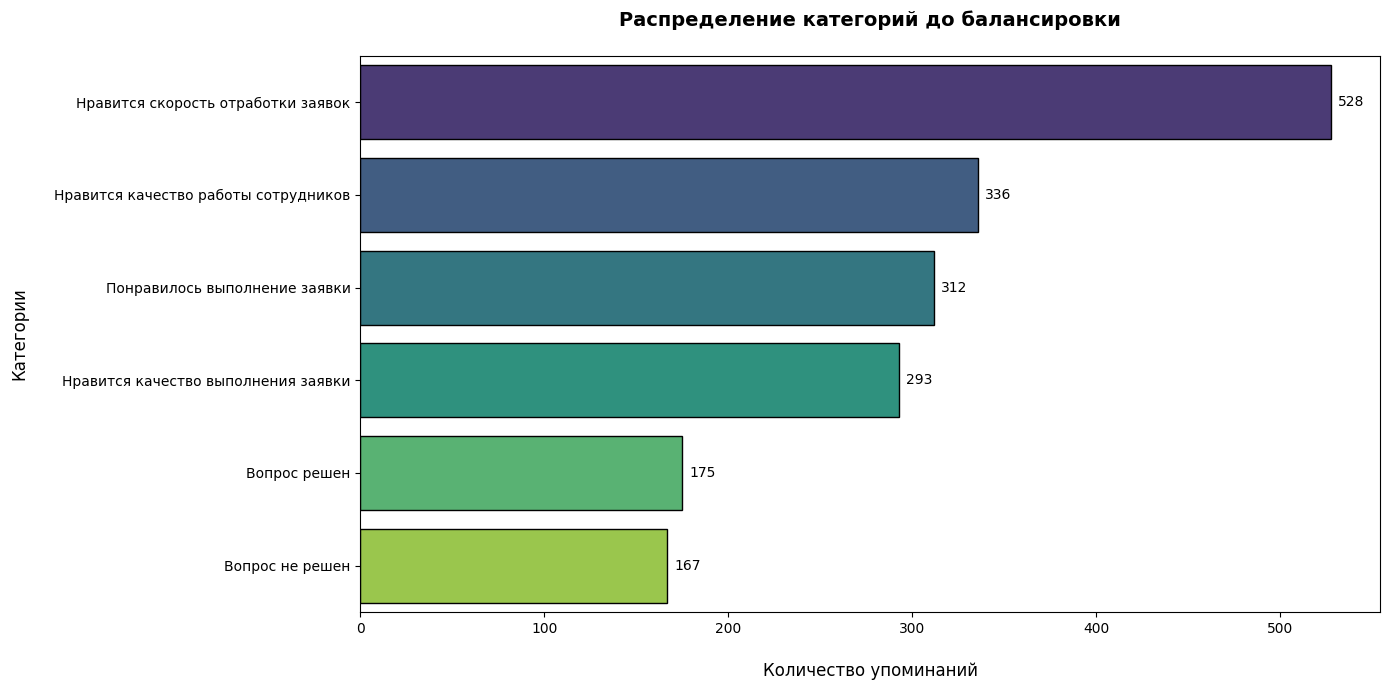

C:\Users\Евгения\AppData\Local\Temp\ipykernel_9980\3818197587.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled['label'] = y_res
C:\Users\Евгения\AppData\Local\Temp\ipykernel_9980\3818197587.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled['lemmatized'] = ''  # Заглушка для синтетических примеров
C:\Users\Евгения\AppData\Local\Temp\ipykernel_9980\3818197587.py:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

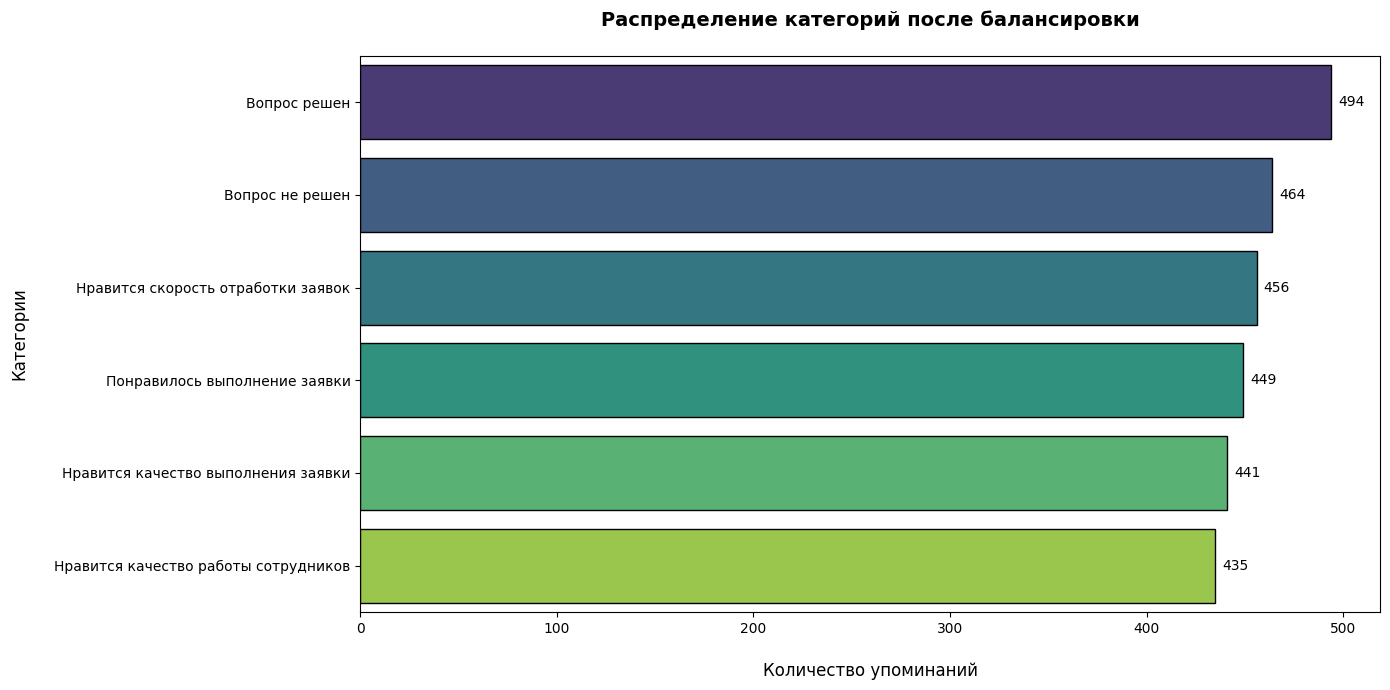

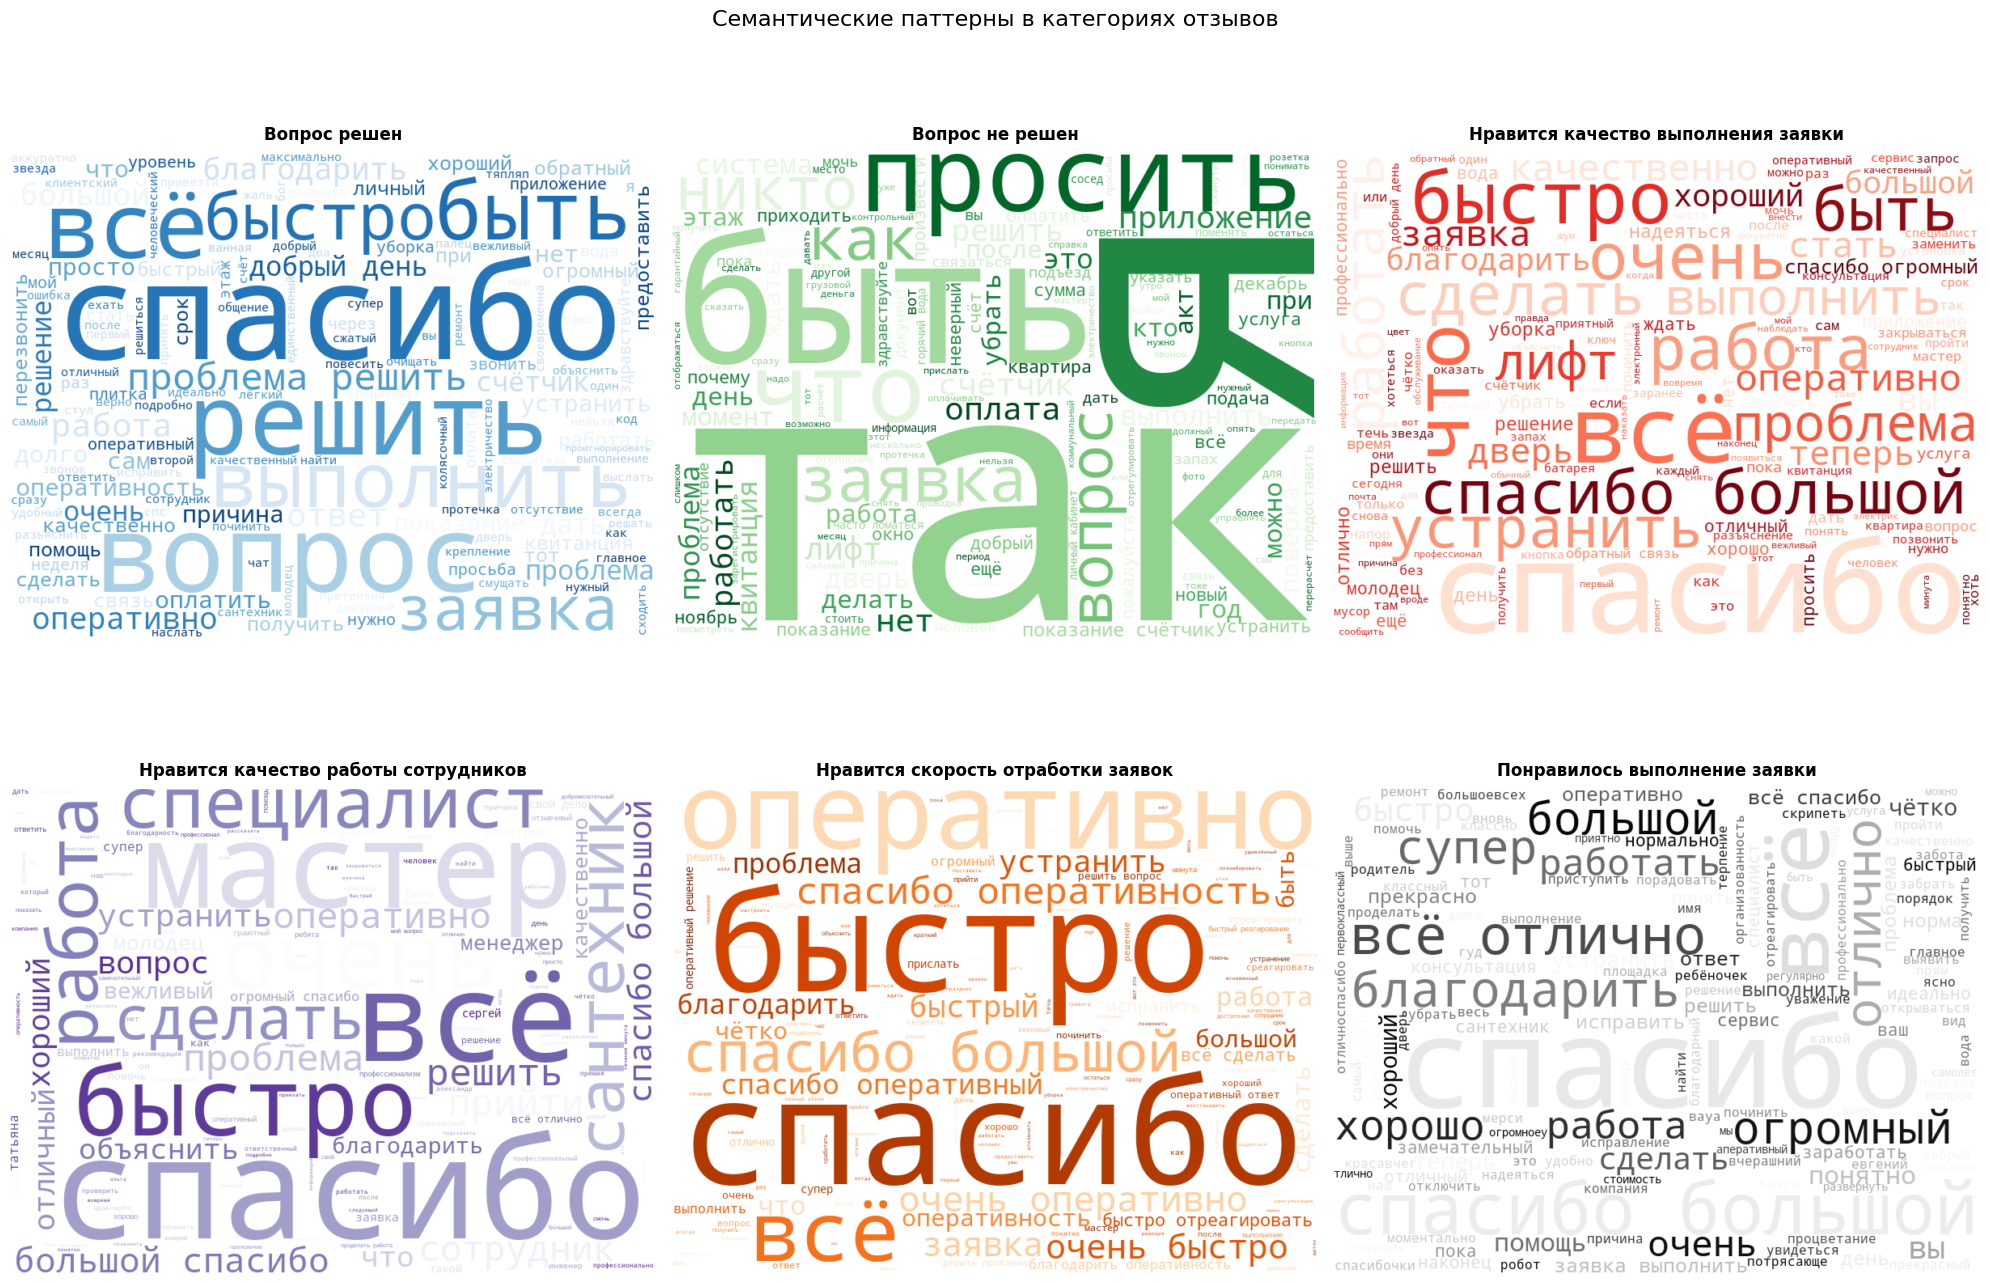


✅ Данные успешно сохранены


In [8]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from collections import Counter

tqdm.pandas(desc="Прогресс обработки")
morph = MorphAnalyzer()

CONFIG = {
    "random_state": 42,
    "max_features": 1000,
    "ngram_range": (1, 2),
    "min_samples": 5,
    "text_columns": {
        'Вопрос решен': ['вопрос решен', 'решен', 'решено', 'статус решен'],
        'Вопрос не решен': ['вопрос не решен', 'вопрос не решен ', 'не решен', 'не решено'],
        'Нравится качество выполнения заявки': ['нравится качество выполнения заявки', 'качество выполнения'],
        'Нравится качество работы сотрудников': ['нравится качество работы сотрудников', 'качество работы'],
        'Нравится скорость отработки заявок': ['нравится скорость отработки заявок', 'скорость обработки'],
        'Понравилось выполнение заявки': ['понравилось выполнение заявки', 'общая оценка'],
        'comment': ['comment', 'текст отзыва', 'отзыв', 'текст']
    }
}

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path, sep=',', encoding='utf-8')
    print("╒════════════════════════════════╕")
    print("│ Обнаруженные столбцы в файле:  │")
    print("╘════════════════════════════════╛")
    print(df.columns.tolist(), '\n')
    
    column_mapping = {}
    for target, variants in CONFIG['text_columns'].items():
        for col in df.columns:
            norm_col = re.sub(r'\s+', ' ', col).strip().lower()
            norm_variants = [re.sub(r'\s+', ' ', v).strip().lower() for v in variants]
            if norm_col in norm_variants:
                column_mapping[col] = target
                break
                
    return df.rename(columns=column_mapping)

class TextPreprocessor:
    def __init__(self, morph):
        self.morph = morph
        self.regex = {
            'clean': re.compile(r'[^а-яё\s]'),
            'spaces': re.compile(r'\s+')
        }
    
    def preprocess(self, text):
        text = str(text).lower()
        text = self.regex['clean'].sub('', text)
        text = self.regex['spaces'].sub(' ', text).strip()
        return text
    
    def lemmatize(self, text):
        words = text.split()
        return ' '.join([
            self.morph.parse(word)[0].normal_form 
            for word in words 
            if len(word) > 2
        ])

def balance_dataset(df, categories):
    df = df.copy()
    df['multi_label'] = df[categories].sum(axis=1)
    df = df[df['multi_label'] <= 1]
    
    labeled = df[df['multi_label'] == 1].copy()
    unlabeled = df[df['multi_label'] == 0].copy()
    
    # Векторизация текста
    tfidf = TfidfVectorizer(
        ngram_range=CONFIG['ngram_range'],
        max_features=CONFIG['max_features'],
        token_pattern=r'(?u)\b[а-яё]{3,}\b'
    )
    tfidf_features = tfidf.fit_transform(labeled['lemmatized'])
    
    # Создание матрицы признаков
    X = pd.DataFrame(tfidf_features.toarray(), 
                    columns=tfidf.get_feature_names_out())
    X['text_length'] = labeled['text_length'].values
    
    y = labeled[categories].idxmax(axis=1)
    
    # Применение ADASYN
    ada = ADASYN(random_state=CONFIG['random_state'], n_neighbors=5)
    X_res, y_res = ada.fit_resample(X, y)
    
    # Восстановление структуры данных
    resampled = pd.DataFrame(X_res, columns=X.columns)
    resampled['label'] = y_res
    resampled['lemmatized'] = ''  # Заглушка для синтетических примеров
    
    # Восстановление оригинальных текстов
    original_indices = X_res.index[X_res.index < len(labeled)]
    resampled.loc[original_indices, 'lemmatized'] = labeled['lemmatized'].values
    
    # Генерация бинарных меток
    for category in categories:
        resampled[category] = (resampled['label'] == category).astype(int)
    
    # Удаление временных столбцов
    resampled.drop(columns=['label', 'text_length'], inplace=True)
    
    # Объединение с неразмеченными данными
    return pd.concat([resampled, unlabeled], axis=0).reset_index(drop=True)

def plot_distribution(df, categories, title):
    plt.figure(figsize=(14, 7))
    distribution = df[categories].sum().sort_values(ascending=False)
    
    ax = sns.barplot(
        x=distribution.values,
        y=distribution.index,
        palette="viridis",
        edgecolor='black'
    )
    
    plt.title(f'{title}\n', fontsize=14, fontweight='bold')
    plt.xlabel('\nКоличество упоминаний', fontsize=12)
    plt.ylabel('Категории\n', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_width()):,}", 
            (p.get_width(), p.get_y() + p.get_height()/2),
            ha='left', va='center',
            fontsize=10,
            color='black',
            xytext=(5, 0),
            textcoords='offset points'
        )
    
    plt.tight_layout()
    plt.show()

def generate_wordclouds(df, categories):
    plt.figure(figsize=(20, 15))
    colors = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'Greys']
    
    for i, (col, color) in enumerate(zip(categories, colors), 1):
        # Фильтрация только оригинальных текстов
        text_data = df[(df[col] == 1) & (df['lemmatized'] != '')]['lemmatized']
        text = ' '.join(text_data)
        
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            colormap=color,
            max_words=150,
            contour_width=1,
            contour_color='steelblue'
        ).generate(text)
        
        plt.subplot(2, 3, i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(col, fontsize=12, pad=10, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle('Семантические паттерны в категориях отзывов\n', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

def main():
    # Загрузка и подготовка данных
    df = load_and_prepare_data('processed_comments.csv')
    
    # Предобработка текста
    preprocessor = TextPreprocessor(morph)
    df['cleaned'] = df['comment'].progress_apply(preprocessor.preprocess)
    df['lemmatized'] = df['cleaned'].progress_apply(preprocessor.lemmatize)
    df['text_length'] = df['lemmatized'].apply(lambda x: len(x.split()))
    
    categories = list(CONFIG['text_columns'].keys())[:-1]
    
    # Визуализация исходного распределения
    plot_distribution(df, categories, 'Распределение категорий до балансировки')
    
    # Балансировка данных
    df_balanced = balance_dataset(df, categories)
    
    # Визуализация после балансировки
    plot_distribution(df_balanced, categories, 'Распределение категорий после балансировки')
    
    # Фильтрация только синтетических данных для TF-IDF
    synthetic_mask = df_balanced['lemmatized'] == ''
    
    # Дополнительная векторизация для финального датасета
    tfidf = TfidfVectorizer(
        ngram_range=CONFIG['ngram_range'],
        max_features=CONFIG['max_features'],
        token_pattern=r'(?u)\b[а-яё]{3,}\b'
    )
    
    tfidf_matrix = tfidf.fit_transform(df_balanced[~synthetic_mask]['lemmatized'])
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"tfidf_{re.sub(r'[^a-z0-9]', '_', col)}" for col in tfidf.get_feature_names_out()]
    )
    
    # Объединение финальных данных
    final_df = pd.concat([
        df_balanced.reset_index(drop=True), 
        tfidf_df.reset_index(drop=True)
    ], axis=1)
    
    # Визуализация и сохранение
    generate_wordclouds(final_df, categories)
    final_df.to_csv('processed_data_final.csv', index=False)
    print("\n✅ Данные успешно сохранены")

if __name__ == "__main__":
    main()


🔍 Анализ топ-20 значимых слов по категориям...


Обработка категорий: 100%|██████████| 6/6 [00:00<00:00, 10.24it/s]


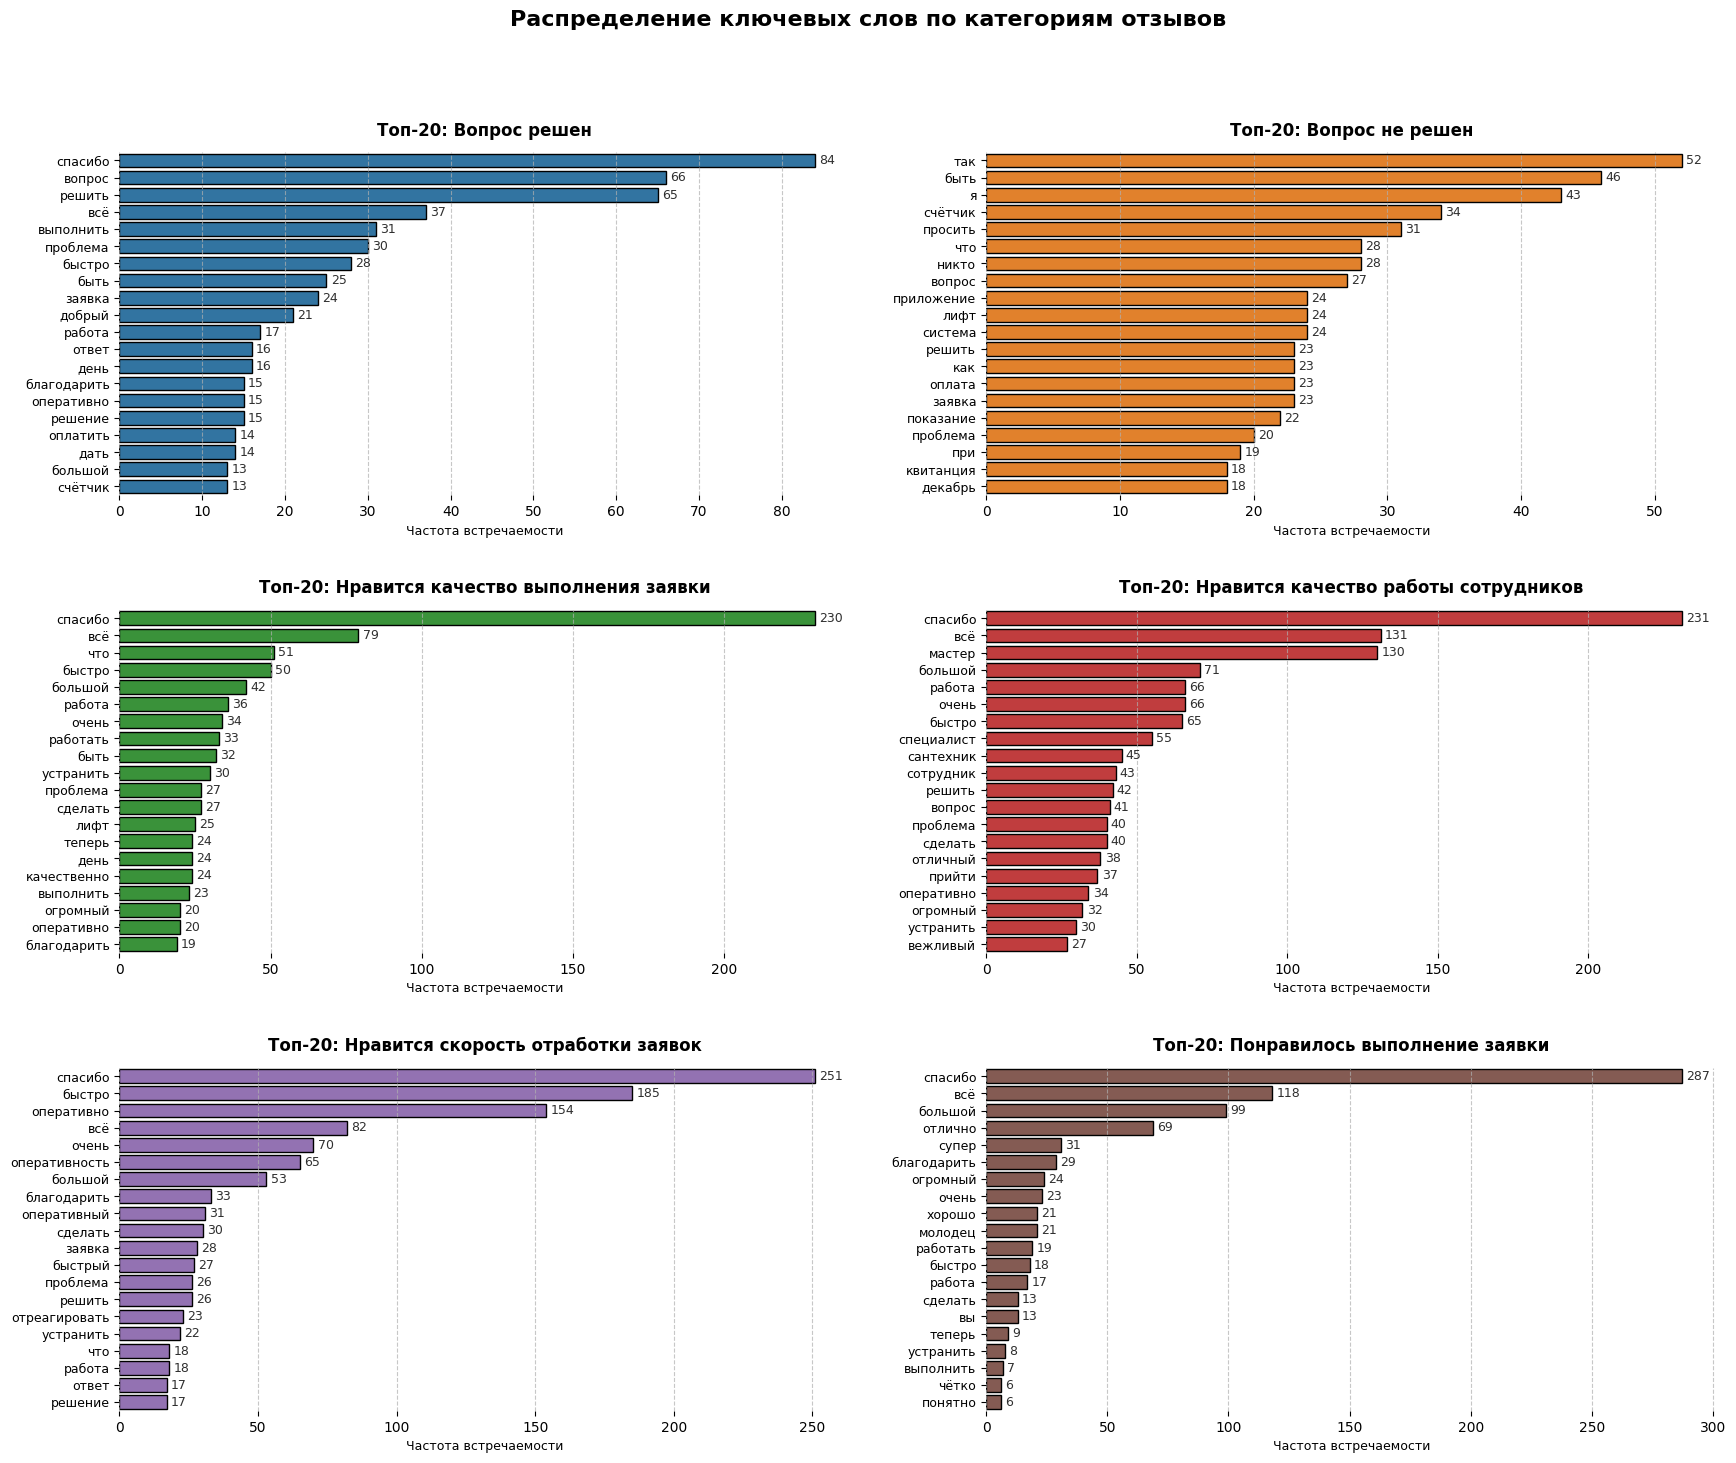

In [9]:
#Визуализация распределения слов по категориям
def load_processed_data(file_path='processed_data_final1.csv'):
    """Загрузка предобработанных данных"""
    df = pd.read_csv(file_path)
    return df

def analyze_top_words(df):
    """Анализ и визуализация топ-20 слов по категориям"""
    print("\n🔍 Анализ топ-20 значимых слов по категориям...")
    
    categories = [
        'Вопрос решен',
        'Вопрос не решен',
        'Нравится качество выполнения заявки',
        'Нравится качество работы сотрудников',
        'Нравится скорость отработки заявок',
        'Понравилось выполнение заявки'
    ]
    
    #Настройка визуализации
    plt.figure(figsize=(18, 15))
    palettes = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    #Прогресс-бар
    pbar = tqdm(zip(categories, palettes), total=len(categories), desc="Обработка категорий")
    
    for i, (category, color) in enumerate(pbar, 1):
        ax = plt.subplot(3, 2, i)
        
        #Фильтрация и подготовка данных
        category_data = df[df[category] == 1]
        texts = category_data['lemmatized'].fillna('').astype(str)
        
        #Подсчет слов
        word_counts = Counter(" ".join(texts).split())
        top_words = word_counts.most_common(20)
        
        #Создание DataFrame для визуализации
        words_df = pd.DataFrame(top_words, columns=['word', 'count'])
        
        #Построение графика
        sns.barplot(x='count', y='word', data=words_df, 
                    ax=ax, color=color, edgecolor='black')
        
        #Аннотации
        ax.bar_label(ax.containers[0], fmt='%d', 
                    padding=3, fontsize=9, color='#2f2f2f')
        
        #Оформление
        ax.set_title(f'Топ-20: {category}', fontsize=12, pad=12, fontweight='bold')
        ax.set_xlabel('Частота встречаемости', fontsize=9)
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelsize=9)
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        #Удаление рамок
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.suptitle('Распределение ключевых слов по категориям отзывов\n', 
                fontsize=16, y=0.99, fontweight='bold')
    plt.tight_layout(pad=3.0)
    plt.show()

if __name__ == "__main__":
    data = load_processed_data()
    analyze_top_words(data)

Обработка текста: 100%|██████████| 2737/2737 [00:02<00:00, 1109.90it/s]



Результаты валидации:


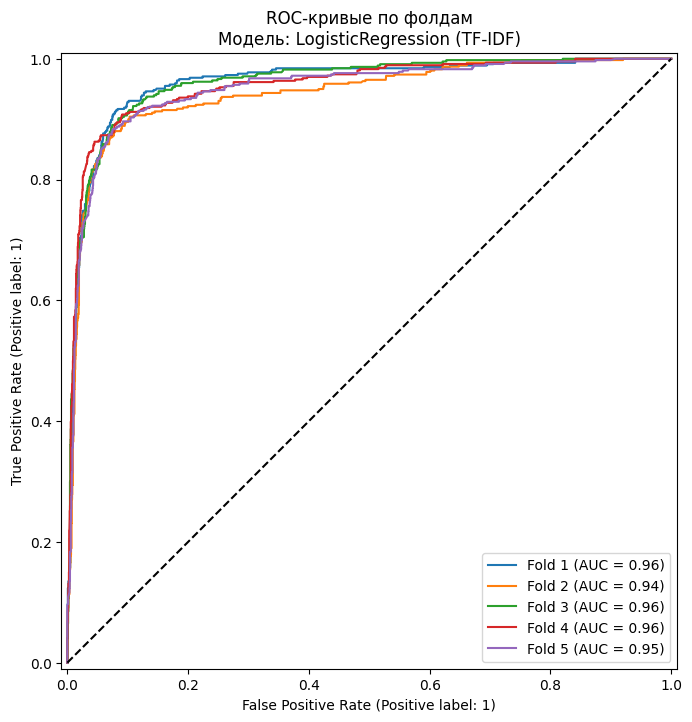

Средний AUC: 0.952
Нравится качество выполнения заявки: 0.919 ± 0.021
Нравится качество работы сотрудников: 0.961 ± 0.010
Нравится скорость отработки заявок: 0.969 ± 0.010
Вопрос решен: 0.921 ± 0.017
Вопрос не решен: 0.990 ± 0.002

Тестовые предсказания:

Отзыв 1:
Текст: Быстро и качественно выполнили работу
Категории: ['Вопрос решен']

Отзыв 2:
Текст: Пришлось ждать три дня, результат плохой
Категории: ['Нравится качество выполнения заявки']

Отзыв 3:
Текст: 
Категории: ['Вопрос не решен']

Отзыв 4:
Текст: Сотрудник опоздал, но проблему решил
Категории: ['Вопрос решен']

Отзыв 5:
Текст: Никто не приехал, обслуживание ужасное
Категории: ['Вопрос не решен']

Отзыв 6:
Текст: Сотрудники работают оперативно, заявка выполнена в срок.
Категории: ['Нравится скорость отработки заявок']

Отзыв 7:
Текст: Качество услуг на высоте, но пришлось долго ждать ответа.
Категории: ['Вопрос решен']

Отзыв 8:
Текст: Проблема осталась нерешенной, очень разочарован.
Категории: ['Нравится качество работы сотр

In [10]:
#Наилучшая модель
morph = MorphAnalyzer()

#Функции препроцессинга текста
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\bне\s+(\w+)', r'не_\1', text)
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    return ' '.join(words)

#Загрузка и подготовка данных
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    df = pd.read_csv(file_path, encoding='utf-8')
    text_column = [col for col in df.columns if df[col].dtype == 'object' and df[col].str.len().mean() > 20][0]
    
    tqdm.pandas(desc="Обработка текста")
    df['processed_text'] = df[text_column].progress_apply(preprocess_text)
    
    categories = [
        'Нравится качество выполнения заявки',
        'Нравится качество работы сотрудников',
        'Нравится скорость отработки заявок',
        'Вопрос решен',
        'Вопрос не решен'
    ]
    df = df.dropna(subset=categories)
    return df['processed_text'].values, df[categories].values, categories

#Пайплайн модели
def build_model():
    return make_pipeline(
        TfidfVectorizer(max_features=10000, ngram_range=(1,2)), 
        OneVsRestClassifier(LogisticRegression(C=0.9, solver='saga', max_iter=1000, class_weight='balanced', random_state=42))
    )
    
#Кросс-валидация
def cross_validate(X, y, categories, n_splits=5, model_name="Logistic Regression"):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'auc_scores': [], 'category_auc': {c: [] for c in categories}}
    
    plt.figure(figsize=(10,8))
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        model = build_model().fit(X[train_idx], y[train_idx])
        y_proba = model.predict_proba(X[test_idx])
        
        results['auc_scores'].append(roc_auc_score(y[test_idx], y_proba, average='macro'))
        for i, cat in enumerate(categories):
            results['category_auc'][cat].append(roc_auc_score(y[test_idx][:,i], y_proba[:,i]))
        
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y[test_idx]).ravel(),
            y_proba.ravel(),
            name=f"Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC-кривые по фолдам\nМодель: {model_name}')
    plt.legend()
    plt.show()
    return results

#Генерация предсказаний
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) for t in texts]
    probas = model.predict_proba(processed)
    predictions = []
    for text, proba in zip(texts, probas):
        max_score = np.max(proba)
        selected = [(cat, score) for cat, score in zip(categories, proba) if score >= max(threshold, max_score)]
        predictions.append({
            'text': text,
            'categories': [cat for cat, _ in selected],
            'probabilities': dict(zip(categories, proba)),
            'max_score': float(max_score)
        })
    return predictions

#Главная функция
def main():
    X, y, cats = load_and_prepare_data()
    model = build_model().fit(X, y)
    
    print("\nРезультаты валидации:")
    cv_results = cross_validate(X, y, cats, model_name="LogisticRegression (TF-IDF)")
    print(f"Средний AUC: {np.mean(cv_results['auc_scores']):.3f}")
    for cat in cats:
        print(f"{cat}: {np.mean(cv_results['category_auc'][cat]):.3f} ± {np.std(cv_results['category_auc'][cat]):.3f}")

    test_texts = [
        "Быстро и качественно выполнили работу",
        "Пришлось ждать три дня, результат плохой",
        "",
        "Сотрудник опоздал, но проблему решил",
        "Никто не приехал, обслуживание ужасное",
        "Сотрудники работают оперативно, заявка выполнена в срок.",
        "Качество услуг на высоте, но пришлось долго ждать ответа.",
        "Проблема осталась нерешенной, очень разочарован.",
        "Быстро приехали и все починили, молодцы!",
        "Сотрудник был вежлив, но решение заняло много времени.",
        "Заявку выполнили некачественно, пришлось переделывать.",
        "Никакой обратной связи, вопрос так и висит.",
        "Молниеносная реакция и профессиональный подход!",
        "Работа сделана хорошо, но сотрудник опоздал на встречу.",
        "До сих пор нет ответа, прошло уже три дня."
    ]
    
    print("\nТестовые предсказания:")
    predictions = predict_with_threshold(model, test_texts, cats)
    for i, pred in enumerate(predictions):
        print(f"\nОтзыв {i+1}:\nТекст: {pred['text']}\nКатегории: {pred['categories']}")

if __name__ == "__main__":
    main()